In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
import json

2025-04-27 14:23:30.666839: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745763810.678276    4813 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745763810.681854    4813 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-27 14:23:30.695086: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

# Print available GPUs
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

# Limit GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


Num GPUs Available: 1


In [3]:
def combine_csv_files(file1, file2, output_file, merge_on=None):
    # Read the CSV files
    df1 = pd.read_csv(file1)
    df2 = pd.read_csv(file2)
    
    # Merge or concatenate based on common column or index
    if merge_on:
        combined_df = pd.merge(df1, df2, on=merge_on, how='outer')
    else:
        combined_df = pd.concat([df1, df2], ignore_index=True)
    
    # Save the combined DataFrame to a new CSV file
    combined_df.to_csv(output_file, index=False)
    print(f"Combined CSV saved to {output_file}")
def max_duplicate_deployment_id_count(df):

    
    # Get the count of each unique deployment_id
    duplicate_counts = df['deployment_id'].value_counts()
    
    # Return the maximum count of duplicates
    max_count = duplicate_counts.max()
    return max_count


In [4]:
# Example usage
combine_csv_files('./datasets/df1_0_optimize.csv', './datasets/df2_1_latency.csv', './datasets/combined_output.csv', merge_on=None)
combine_csv_files('./datasets/combined_output.csv', './datasets/df3_23_scaling.csv', './datasets/combined_output.csv', merge_on=None)
combine_csv_files('./datasets/combined_output.csv', './datasets/df4_1_migrate.csv', './datasets/combined_output.csv', merge_on=None)


Combined CSV saved to ./datasets/combined_output.csv
Combined CSV saved to ./datasets/combined_output.csv
Combined CSV saved to ./datasets/combined_output.csv


In [7]:
# Load dataset
file_path = "./datasets/combined_output.csv"
df = pd.read_csv(file_path)
max_duplicate_deployment_id_count(df)
# Feature selection 
num_features = ['replicas','initial_cpu','applied_cpu', 'initial_avg_memory_consumption', 'applied_memory_consumption', 'initial_avg_latency', 'applied_latency']
X_numeric = df[num_features].values
deployment_ids = df['deployment_id'].values
y = df['label'].values

In [8]:
len(df)

12000

In [9]:
max_duplicate_deployment_id_count(df)

np.int64(1)

In [10]:
deployment_id_mapping = {int(dep_id): i for i, dep_id in enumerate(df['deployment_id'].unique())}

In [11]:

# Normalize features
scaler = StandardScaler()
X_numeric = scaler.fit_transform(X_numeric)

# Convert deployment_id to categorical
deployment_id_unique = df['deployment_id'].nunique()
deployment_id_mapping = {dep_id: i for i, dep_id in enumerate(df['deployment_id'].unique())}
deployment_ids = np.array([deployment_id_mapping[d] for d in deployment_ids])  # Convert to integer IDs

# Split dataset (80% training, 20% testing)
X_num_train, X_num_test, dep_train, dep_test, y_train, y_test = train_test_split(
    X_numeric, deployment_ids, y, test_size=0.2, random_state=42
)

In [12]:
joblib.dump(scaler, './models/scaler-meta-v9-2.pkl')

['./models/scaler-meta-v9-2.pkl']

In [13]:
# Define the neural network model
# Two inputs: deployment_id and numerical features
deployment_input = layers.Input(shape=(1,), name="deployment_id")
numeric_input = layers.Input(shape=(7,), name="numeric_features")

# Embedding layer for deployment_id
embedding_dim = 4  # Number of embedding dimensions
deployment_embedding = layers.Embedding(input_dim=deployment_id_unique+200, output_dim=embedding_dim)(deployment_input)
deployment_embedding = layers.Flatten()(deployment_embedding)
merged = layers.Concatenate()([deployment_input, numeric_input])

I0000 00:00:1745763837.906377    4813 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1685 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050, pci bus id: 0000:08:00.0, compute capability: 8.6


In [14]:
# Concatenate embedded deployment_id with numerical features
merged = layers.Concatenate()([deployment_embedding, numeric_input])

# Dense layers
x = layers.Dense(62, activation='relu')(merged)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(16, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)  # 4 classes

# Define the model
model = keras.Model(inputs=[deployment_input, numeric_input], outputs=output)

# Compile the model
optimizer = optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


In [15]:
# Train the model
history = model.fit(
    [dep_train, X_num_train], y_train,
    epochs=30, batch_size=12, verbose=1,
    validation_data=([dep_test, X_num_test], y_test),
    callbacks=[early_stopping,reduce_lr]
)

# Evaluate the model
loss, accuracy = model.evaluate([dep_test, X_num_test], y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/30


I0000 00:00:1745763848.796400    4882 service.cc:148] XLA service 0x7f8ac0d10950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745763848.796446    4882 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050, Compute Capability 8.6
2025-04-27 14:24:08.801811: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745763848.815330    4882 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745763848.881883    4882 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


800/800 [==============================] - 7s 6ms/step - loss: 0.7874 - accuracy: 0.6643 - val_loss: 0.3513 - val_accuracy: 0.8321 - lr: 0.0050
Epoch 2/30
800/800 [==============================] - 5s 6ms/step - loss: 0.5165 - accuracy: 0.7898 - val_loss: 0.3012 - val_accuracy: 0.8750 - lr: 0.0050
Epoch 3/30
800/800 [==============================] - 5s 6ms/step - loss: 0.4456 - accuracy: 0.8331 - val_loss: 0.1901 - val_accuracy: 0.9454 - lr: 0.0050
Epoch 4/30
800/800 [==============================] - 5s 6ms/step - loss: 0.3447 - accuracy: 0.8737 - val_loss: 0.2112 - val_accuracy: 0.9292 - lr: 0.0050
Epoch 5/30
800/800 [==============================] - 5s 7ms/step - loss: 0.2996 - accuracy: 0.8991 - val_loss: 0.2000 - val_accuracy: 0.9196 - lr: 0.0050
Epoch 6/30
800/800 [==============================] - 5s 6ms/step - loss: 0.2694 - accuracy: 0.9093 - val_loss: 0.2116 - val_accuracy: 0.9133 - lr: 0.0050
Epoch 7/30
800/800 [==============================] - 5s 6ms/step - loss: 0.1859 

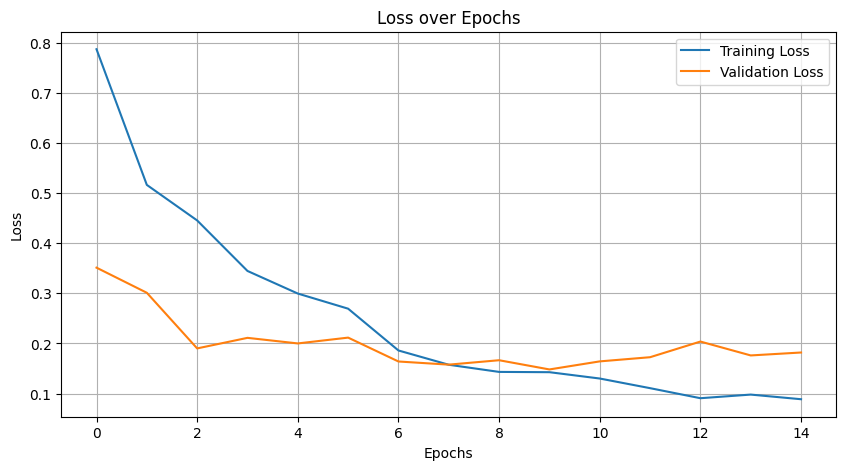

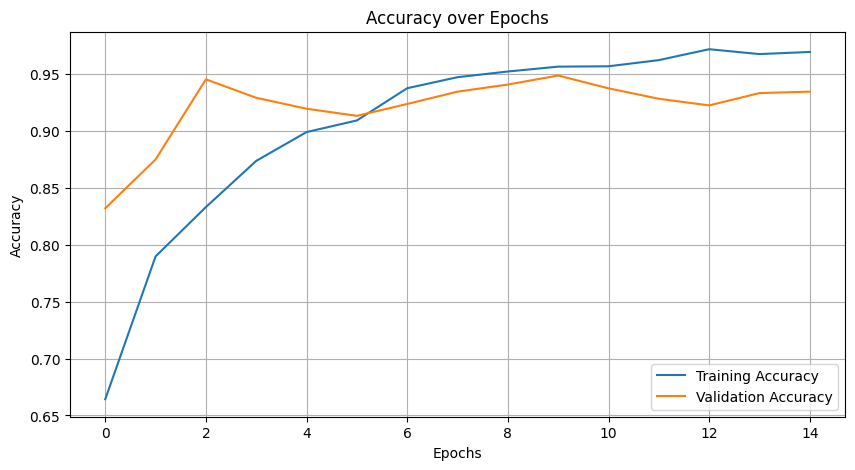

In [16]:
import matplotlib.pyplot as plt

# Get the training history
history_dict = history.history

# Plotting loss
plt.figure(figsize=(10, 5))
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting accuracy if available
if 'accuracy' in history_dict:
    plt.figure(figsize=(10, 5))
    plt.plot(history_dict['accuracy'], label='Training Accuracy')
    plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [17]:
model.save('./models/model-meta-v9-2.h5')

/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
def save_embeddings(deployment_id_mapping, file_path='./models/deployment_embeddings.json'):
    with open(file_path, 'w') as f:
        json.dump(deployment_id_mapping, f)

# Example usage after updating the embeddings
deployment_id_mapping_str= {str(dep_id): i for i, dep_id in enumerate(df['deployment_id'].unique())}
save_embeddings(deployment_id_mapping_str)

In [45]:
new_deployment_id_idx=np.array([[71345134]])

In [212]:
# Should return a 2
new_data = np.array([[ 1, 1,1, 200, 350, 15, 15]])
new_numeric_features = scaler.transform(new_data) 
predicted_probs = model.predict([new_deployment_id_idx, new_numeric_features])
predicted_class = np.argmax(predicted_probs, axis=1)  # Get the class with the highest probability

print(f"Predicted action: {predicted_class[0]}")
# Should return a 0 > IS WRONG. WHY DOWNSCALE AT ALL?
new_data = np.array([[ 1, 1,1, 200, 220, 15, 15]])
new_numeric_features = scaler.transform(new_data) 
predicted_probs = model.predict([new_deployment_id_idx, new_numeric_features])
predicted_class = np.argmax(predicted_probs, axis=1)  # Get the class with the highest probability

print(f"Predicted action: {predicted_class[0]}")

1/1 [==============================] - 0s 14ms/step
Predicted action: 2
1/1 [==============================] - 0s 13ms/step
Predicted action: 2


In [197]:
# LATENCY TEST
# Should return a 1
new_data = np.array([[ 1, 1,1, 200, 200, 15, 28]])
new_numeric_features = scaler.transform(new_data) 
predicted_probs = model.predict([new_deployment_id_idx, new_numeric_features])
predicted_class = np.argmax(predicted_probs, axis=1)
print(f"Predicted action: {predicted_class[0]}")

1/1 [==============================] - 0s 13ms/step
Predicted action: 1


In [198]:

# Should return a 1 because LATENCY. WHY RETURN 3???
new_data = np.array([[ 1, 1,1, 400, 400, 35,46]])
new_numeric_features = scaler.transform(new_data) 
predicted_probs = model.predict([new_deployment_id_idx, new_numeric_features])
predicted_class = np.argmax(predicted_probs, axis=1)
print(f"Predicted action: {predicted_class[0]}")

1/1 [==============================] - 0s 13ms/step
Predicted action: 2


In [321]:
# CPU TEST

In [199]:
# Should return a 0 
new_data = np.array([[ 1, 1,1, 200, 200, 16,16]])
new_numeric_features = scaler.transform(new_data) 
predicted_probs = model.predict([new_deployment_id_idx, new_numeric_features])
predicted_class = np.argmax(predicted_probs, axis=1)
print(f"Predicted action: {predicted_class[0]}")

1/1 [==============================] - 0s 15ms/step
Predicted action: 0


In [200]:
# CPU Latency return 1!
new_data = np.array([[ 1, 1,0.5, 200, 50, 16,23]])
new_numeric_features = scaler.transform(new_data) 
predicted_probs = model.predict([new_deployment_id_idx, new_numeric_features])
predicted_class = np.argmax(predicted_probs, axis=1)
print(f"Predicted action: {predicted_class[0]}")

1/1 [==============================] - 0s 30ms/step
Predicted action: 1


In [201]:
# Should return a 1 > migrate away!
new_data = np.array([[ 1, 2,0.2, 200, 100, 16,16]])
new_numeric_features = scaler.transform(new_data) 
predicted_probs = model.predict([new_deployment_id_idx, new_numeric_features])
predicted_class = np.argmax(predicted_probs, axis=1)
print(f"Predicted action: {predicted_class[0]}")
assert predicted_class[0] == 1
# Should return a 3
new_data = np.array([[ 2, 2,1, 200, 100, 16,16]])
new_numeric_features = scaler.transform(new_data) 
predicted_probs = model.predict([new_deployment_id_idx, new_numeric_features])
predicted_class = np.argmax(predicted_probs, axis=1)
print(f"Predicted action: {predicted_class[0]}")
assert predicted_class[0] == 3
# Should return a 2 scale up!
new_data = np.array([[ 1, 1,2, 200, 100, 16,16]])
new_numeric_features = scaler.transform(new_data) 
predicted_probs = model.predict([new_deployment_id_idx, new_numeric_features])
predicted_class = np.argmax(predicted_probs, axis=1)
print(f"Predicted action: {predicted_class[0]}")
assert predicted_class[0] == 2

1/1 [==============================] - 0s 14ms/step
Predicted action: 1
1/1 [==============================] - 0s 13ms/step
Predicted action: 3
1/1 [==============================] - 0s 12ms/step
Predicted action: 2
